In [ ]:
# Multiclass classification

# nonlinear classifier - the RandomForestClassifier. It requires little hyperparameter tuning.

# No need for imputing the missing data --> data description.

# Problem: You can't see every tree.. predict the health of the tree.

In [1]:
# Import third-party packages.
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
import seaborn as sns
from shapely.geometry import Point
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

%matplotlib inline

# Change display settings for dataframes.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Read in data on trees.
#df_1995 = pd.read_csv('./data/nyc_trees/nyc_tree_census_1995.csv.gz', compression='gzip')
#df_2005 = pd.read_csv('./data/nyc_trees/nyc_tree_census_2005.csv.gz', compression='gzip')
df_2015 = pd.read_csv('./data/nyc_trees/nyc_tree_census_2015.csv.gz', compression='gzip')
#df_1995.drop('Unnamed: 0', axis=1, inplace=True)
#df_2005.drop('Unnamed: 0', axis=1, inplace=True)
df_2015.drop('Unnamed: 0', axis=1, inplace=True)

In [18]:
# Read in geographic data on New York City.
nyc = gpd.read_file('./data/nyc/nyc_geo.shp')

In [28]:
test = df_2015.copy()

In [29]:
test.drop(['block_id', 'created_at', 'tree_dbh', 'stump_diam', 'curb_loc', 'spc_latin', 'spc_common', 'user_type', 'problems', 'address', 'postcode', 'zip_city', 'community board', 'borocode', 'borough', 'cncldist', 'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state', 'x_sp', 'y_sp', 'council district', 'census tract', 'bin', 'bbl'], axis=1, inplace=True)

In [30]:
test_geo = gpd.GeoDataFrame(test, geometry=[Point(coordinates) for coordinates in zip(test['longitude'], test['latitude'])])

In [31]:
# Create circles with a 20m radius around each tree location. But since the radius of a tree might just touch another, the
# maximum distance between such trees should be 20m and thus a radius of 10m each.
test_geo.crs = {'init': 'epsg:4326', 'no_defs': True}
test_geo = test_geo.to_crs(epsg=3857)
test_geo.crs = {'init': 'epsg:3857', 'no_defs': True}
buffers = test_geo.buffer(4.5)
test_geo = test_geo.to_crs(epsg=4326)
test_geo.crs = {'init': 'epsg:4326', 'no_defs': True}
buffers = buffers.to_crs(epsg=4326)
buffers.crs = {'init': 'epsg:4326', 'no_defs': True}
buffers_gdf = gpd.GeoDataFrame(buffers, geometry=buffers)
buffers_gdf.rename(columns={0:'circles'}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [32]:
res = gpd.sjoin(test_geo, buffers_gdf, how='right')
res.drop('index_left', axis=1, inplace=True)

In [51]:
n_neighbors = res.groupby('tree_id').count()
n_neighbors.rename(columns={'circles': 'n_neighbors'}, inplace=True)
test_new = pd.merge(test, n_neighbors[['n_neighbors']], on='tree_id', right_index=True)

In [52]:
res_2 = pd.merge(res, n_neighbors['n_neighbors'], on='tree_id')

In [53]:
res_2['circs_lat'] = res_2.geometry.centroid.y.values

In [54]:
res_2['circs_long'] = res_2.geometry.centroid.x.values

In [58]:
from geopy.distance import geodesic

res_2['distance'] = [geodesic((res_2['latitude'].loc[i], res_2['longitude'].loc[i]), (res_2['circs_lat'].loc[i], res_2['circs_long'].loc[i])).meters for i in res_2.index]

In [70]:
# 3m
res_2[res_2['circles_y'] > 1]['circles_y'].count() / len(res_2)

0.025104969768131206

In [71]:
# Number of neighboring trees in a 3m radius per tree on average.
res_2[res_2['circles_y'] > 1]['circles_y'].mean()

6.91654725740815

In [72]:
# Average distance of a street tree to another street tree in New York.
res_2[(res_2['circles_y'] > 1) & (res_2['circs_lat'] != res_2['latitude']) & (res_2['circs_long'] != res_2['longitude'])]['distance_geopy'].mean()

0.7498945668019268

In [56]:
# 4.5m
res_2[res_2['n_neighbors'] > 1]['n_neighbors'].count() / len(res_2)

0.06679096724193123

In [57]:
# Number of neighboring trees in a 4.5m radius per tree on average.
res_2[res_2['n_neighbors'] > 1]['n_neighbors'].mean()

5.068275456150677

In [61]:
# Average distance of a street tree to another street tree in New York.
res_2[(res_2['n_neighbors'] > 1) & \
      (res_2['circs_lat'] != res_2['latitude']) & \
      (res_2['circs_long'] != res_2['longitude'])]['distance'].mean()

1.4196490327659852

In [118]:
# 9m
res_2[res_2['circles_y'] > 1]['circles_y'].count() / len(res_2)

0.4481354879481572

In [119]:
# Number of neighboring trees with a 9m radius per tree on average.
res_2[res_2['circles_y'] > 1]['circles_y'].mean()

2.8565803661210794

In [120]:
# Average distance of a street tree to another street tree in New York.
res_2[(res_2['circles_y'] > 1) & (res_2['circs_lat'] != res_2['latitude']) & (res_2['circs_long'] != res_2['longitude'])]['distance_geopy'].mean()

3.3064958383325758

In [103]:
# 5m
res_2[res_2['circles_y'] > 1]['circles_y'].count() / len(res_2)

0.0853620942478171

In [104]:
# Number of neighboring trees with a 10m radius per tree on average.
res_2[res_2['circles_y'] > 1]['circles_y'].mean()

4.502513298521302

In [105]:
# Average distance of a street tree to another street tree in New York.
res_2[(res_2['circles_y'] > 1) & (res_2['circs_lat'] != res_2['latitude']) & (res_2['circs_long'] != res_2['longitude'])]['distance_geopy'].mean()

1.5929308784771194

In [63]:
test_new

,tree_id,status,health,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,latitude,longitude,geometry,n_neighbors
0,180683,Alive,Fair,None,None,NoDamage,No,No,No,No,No,No,No,No,No,40.723092,-73.844215,POINT (-73.84422 40.72309),1
1,200540,Alive,Fair,None,None,Damage,Yes,No,No,No,No,No,No,No,No,40.794111,-73.818679,POINT (-73.81868 40.79411),1
2,204026,Alive,Good,1or2,None,Damage,No,No,No,No,No,No,No,No,No,40.717581,-73.936608,POINT (-73.93661 40.71758),1
3,204337,Alive,Good,None,None,Damage,Yes,No,No,No,No,No,No,No,No,40.713537,-73.934456,POINT (-73.93446 40.71354),1
4,189565,Alive,Good,None,None,Damage,Yes,No,No,No,No,No,No,No,No,40.666778,-73.975979,POINT (-73.97598 40.66678),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683783,155433,Alive,Good,None,None,Damage,No,No,No,No,No,No,No,No,No,40.713211,-73.954944,POINT (-73.95494 40.71321),1
683784,183795,Alive,Good,1or2,None,NoDamage,No,No,No,No,No,No,No,No,No,40.715194,-73.856650,POINT (-73.85665 40.71519),1
683785,166161,Alive,Good,None,None,Damage,No,No,No,No,No,No,No,No,No,40.620762,-74.136517,POINT (-74.13652 40.62076),1
683786,184028,Alive,Good,None,None,NoDamage,No,No,No,No,No,No,No,No,No,40.850828,-73.903115,POINT (-73.90311 40.85083),1


In [64]:
# Encode the feature on the number of neighboring trees.
test_new.loc[test_new['n_neighbors'] == 1, 'n_neighbors'] = 0.1
test_new.loc[test_new['n_neighbors'] == 2, 'n_neighbors'] = 0.2
test_new.loc[test_new['n_neighbors'] >= 3, 'n_neighbors'] = 0.3

In [65]:
test_new.loc[test_new['n_neighbors'] == 0.1, 'n_neighbors'] = "no neighbor"
test_new.loc[test_new['n_neighbors'] == 0.2, 'n_neighbors'] = "one neighbor"
test_new.loc[test_new['n_neighbors'] == 0.3, 'n_neighbors'] = "two or more neighbors"

In [66]:
test_new.n_neighbors.value_counts()

no neighbor              664680
one neighbor              15134
two or more neighbors      3974
Name: n_neighbors, dtype: int64

In [13]:
test_new.tree_dbh.corr(test_new.health)

0.07423817812763712

In [ ]:
# Nur für einen Eintrag
neighbors = []
for ind, i in enumerate(test_geo.index):
    print(ind)
    if test_geo['geometry'].loc[0].intersects(buffers.loc[i]):
        neighbors.append(i)

In [ ]:
# Circa mehr als 2 Tage Rechenaufwand..
test_geo = test_geo.to_crs(epsg=3857)
test_geo.crs = {'init': 'epsg:3857', 'no_defs': True}

xs_all = test_geo['geometry'].x
ys_all = test_geo['geometry'].y
pot_neighbors = np.array(list(zip(xs_all, ys_all)))

def n_neighbors(point, size=3, distance=10.0, potential_neighbors=pot_neighbors):
    point = point.reshape(-1, 2)
    bin_trie = cKDTree(point)
    remaining_points = np.delete(potential_neighbors, np.where(potential_neighbors == point), axis=0).reshape(-1, 2)
    dist, ids = bin_trie.query(remaining_points, k=size, distance_upper_bound=distance, n_jobs=-1)
    count_neighbors = len(dist[dist != np.inf])
    
    return count_neighbors

inp = np.array(list(zip(test_geo['geometry'].x.values, test_geo['geometry'].y.values)))

test_geo['n_neighbors'] = [n_neighbors(i) for i in inp]

In [ ]:
nyc = nyc.to_crs(epsg=4326)
nyc.crs = {'init': 'epsg:4326', 'no_defs': True}
circles = buffers.unary_union
a = nyc['geometry'].intersection(circles)

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
sns.set(style='whitegrid')
sns.mpl.rc('figure')
fig, ax = plt.subplots()
a.plot(ax=ax)

In [ ]:
tree_radi = nyc.intersection(trees_geo_circs)
tree_radi.plot(ax=ax)

In [67]:
df_sel = test_new[['tree_id',
               'steward',
               'guards',
               'sidewalk',
               'root_stone',
               'root_grate',
               'root_other',
               'trunk_wire',
               'trnk_light',
               'trnk_other',
               'brch_light',
               'brch_shoe',
               'brch_other',
               'n_neighbors',
               'health']]

# Replace NaN values in features with entries signalling this tree is either dead or a stump.
df_sel['steward'].fillna('Dead|Stump', inplace=True)
df_sel['guards'].fillna('Dead|Stump', inplace=True)

# In 'steward', replace spectrum of answers to yes (= alive) or no (= dead/stump).
df_sel['steward'].replace(['1or2', '3or4', '4orMore', 'None'], 'Alive', inplace=True)

# Replace NaN values in the target with entries signalling this tree is either dead or a stump.
df_sel['health'].fillna('Dead|Stump', inplace=True)

#df_sel['health'].replace(['Poor', 'Fair'], 'Poor|Fair', inplace=True)

# One-hot encoding the categorical features and the target.
df_sel_enc = pd.get_dummies(df_sel)

C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


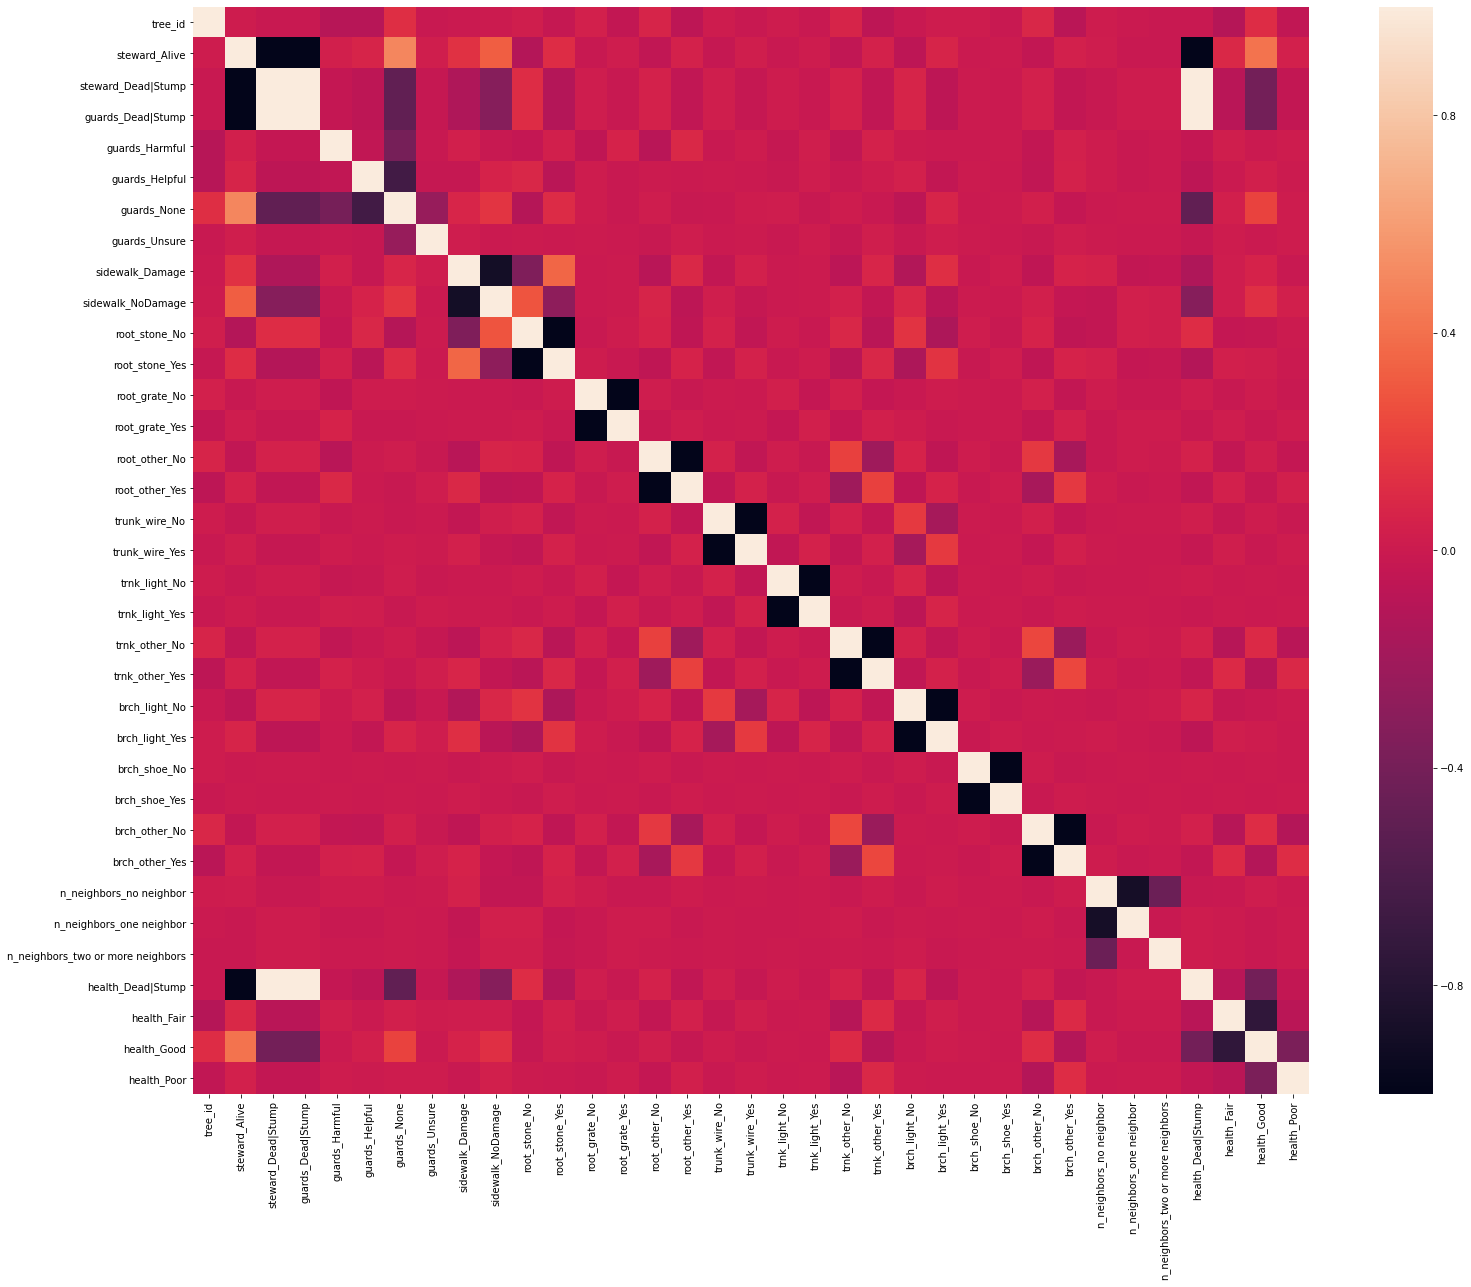

In [68]:
corrmat = df_sel_enc.corr()
plt.subplots(figsize=(25,20))
sns.heatmap(corrmat, annot=False)
plt.show()

In [75]:
x = df_sel_enc[list(df_sel_enc.columns)[1:31]]
y = df_sel_enc[list(df_sel_enc.columns)[31:]]

# Split into train, test, and validation datasets, with stratification as some labels were not predicted in previous runs.
# x_train_vali, x_test, y_train_vali, y_test = train_test_split(x, y, random_state=0)
# x_train, x_vali, y_train, y_vali = train_test_split(x_train_vali, y_train_vali, random_state=0)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=None, stratify=y)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BB47EF8080>,
      dtype=object)

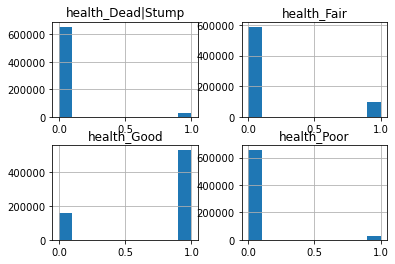

In [80]:
y.hist()

In [101]:
target_first_class = len(y.loc[y['health_Dead|Stump'] == 0]) / len(y)
target_second_class = len(y.loc[y['health_Fair'] == 0]) / len(y)
target_third_class = len(y.loc[y['health_Good'] == 0]) / len(y)
target_fourth_class = len(y.loc[y['health_Poor'] == 0]) / len(y)


class_weight_orig = [{0:target_first_class, 1:1-target_first_class},
                     {0:target_second_class, 1:1-target_second_class},
                     {0:target_third_class, 1:1-target_third_class},
                     {0:target_fourth_class, 1:1-target_fourth_class}]

class_weight_manip = [{0:target_first_class, 1:1-target_first_class/2},
                      {0:target_second_class/2, 1:1-target_second_class/2},
                      {0:target_third_class, 1:1-target_third_class/2},
                      {0:target_fourth_class/2, 1:1-target_fourth_class/2}]

In [20]:
from imblearn.under_sampling import RandomUnderSampler

rs = RandomUnderSampler(sampling_strategy='majority', random_state=None)
x_train_rs_fair, y_train_rs_fair = rs.fit_sample(x_train, y_train['health_Fair'])
x_train_rs_poor, y_train_rs_poor = rs.fit_sample(x_train, y_train['health_Poor'])


health_fair_rs = pd.concat([x_train_rs_fair, y_train_rs_fair], axis=1)
health_poor_rs = pd.concat([x_train_rs_poor, y_train_rs_poor], axis=1)
health_fair_rs = health_fair_rs[health_fair_rs.health_Fair == 1]
health_poor_rs = health_poor_rs[health_poor_rs.health_Poor == 1]

df_sel_enc_rs = pd.concat([df_sel_enc, health_fair_rs, health_poor_rs], ignore_index=True)
df_sel_enc_rs.fillna(0, inplace=True)
df_sel_enc_rs[df_sel_enc_rs.columns[-4:]] = df_sel_enc_rs[df_sel_enc_rs.columns[-4:]].astype(int)

C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\ph

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001940D991518>,
      dtype=object)

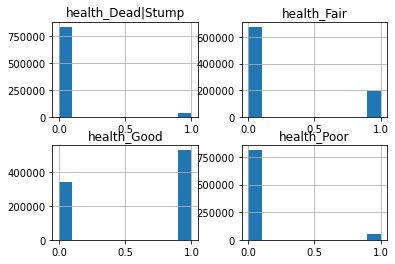

In [21]:
df_sel_enc_rs[['health_Dead|Stump', 'health_Fair', 'health_Good', 'health_Poor']].hist()

In [82]:
from imblearn.over_sampling import SMOTE

smote_sampler = SMOTE(sampling_strategy='not majority', random_state=None, n_jobs=-1)
x_train_smo_fair, y_train_smo_fair = smote_sampler.fit_sample(x_train, y_train['health_Fair'])
x_train_smo_poor, y_train_smo_poor = smote_sampler.fit_sample(x_train, y_train['health_Poor'])
x_train_smo_good, y_train_smo_good = smote_sampler.fit_sample(x_train, y_train['health_Good'])
x_train_smo_deadstump, y_train_smo_deadstump = smote_sampler.fit_sample(x_train, y_train['health_Dead|Stump'])

In [83]:
health_fair = pd.concat([x_train_smo_fair, y_train_smo_fair], axis=1)
health_poor = pd.concat([x_train_smo_poor, y_train_smo_poor], axis=1)
health_fair = health_fair[health_fair.health_Fair != 0]
health_poor = health_poor[health_poor.health_Poor != 0]
health_good = pd.concat([x_train_smo_good, y_train_smo_good], axis=1)
health_good = health_good[health_good.health_Good != 0]
health_deadstump = pd.concat([x_train_smo_deadstump, y_train_smo_deadstump], axis=1)
health_deadstump = health_deadstump[health_deadstump['health_Dead|Stump'] != 0]
df_sel_enc_smo = pd.concat([health_fair, health_poor, health_good, health_deadstump], ignore_index=True)
#df_sel_enc_smo = pd.concat([df_sel_enc, health_fair, health_poor], ignore_index=True)
df_sel_enc_smo.fillna(0, inplace=True)
df_sel_enc_smo[df_sel_enc_smo.columns[-4:]] = df_sel_enc_smo[df_sel_enc_smo.columns[-4:]].astype(int)

In [283]:
df_sel_enc_smo.drop_duplicates(inplace=True)

C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\ph

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BB4DED77B8>,
      dtype=object)

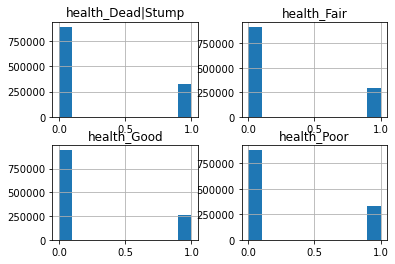

In [84]:
df_sel_enc_smo[['health_Dead|Stump', 'health_Fair', 'health_Good', 'health_Poor']].hist()

In [91]:
x_new = df_sel_enc_smo[list(df_sel_enc_smo.columns)[0:30]]
y_new = df_sel_enc_smo[list(df_sel_enc_smo.columns)[30:]]

# Split into train, test, and validation datasets, with stratification as some labels were not predicted in previous runs.
# x_train_vali, x_test, y_train_vali, y_test = train_test_split(x, y, random_state=0)
# x_train, x_vali, y_train, y_vali = train_test_split(x_train_vali, y_train_vali, random_state=0)

x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_new, y_new, test_size=0.2, random_state=None, stratify=y_new)

C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\phill\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\ph

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BA204B8908>,
      dtype=object)

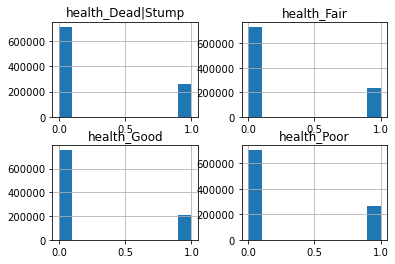

In [94]:
y_train_new.hist()

In [95]:
rdf_clf = RandomForestClassifier()
rdf_clf.fit(x_train_new, y_train_new)
y_pred_new = rdf_clf.predict(x_test_new)
print(accuracy_score(y_test_new, y_pred_new))

0.31275151735057394


In [102]:
rdf_clf = RandomForestClassifier(class_weight=class_weight_manip)
rdf_clf.fit(x_train_new, y_train_new)
y_pred_new = rdf_clf.predict(x_test_new)
print(accuracy_score(y_test_new, y_pred_new))

0.5332291529225491


In [98]:
print(classification_report(y_test_new, y_pred_new, target_names=y_new.columns))
#print("F1-score of positive classes:", f1_score(y_test_new, y_pred_new, labels=np.unique(y_pred_new), average=None))
#print("F1-score (micro):", f1_score(y_test_new, y_pred_new, labels=np.unique(y_pred_new), average='micro'))
#print("F1-score (macro):", f1_score(y_test_new, y_pred_new, labels=np.unique(y_pred_new), average='macro'))
#print("F1-score (weighted):", f1_score(y_test_new, y_pred_new, labels=np.unique(y_pred_new), average='weighted'))

                   precision    recall  f1-score   support

      health_Fair       0.65      0.03      0.05     58729
      health_Poor       0.67      0.13      0.22     65697
      health_Good       0.67      0.01      0.01     52885
health_Dead|Stump       1.00      1.00      1.00     65217

        micro avg       0.94      0.31      0.47    242528
        macro avg       0.75      0.29      0.32    242528
     weighted avg       0.75      0.31      0.34    242528
      samples avg       0.31      0.31      0.31    242528



In [103]:
print(classification_report(y_test_new, y_pred_new, target_names=y_new.columns))

                   precision    recall  f1-score   support

      health_Fair       0.78      0.01      0.01     58729
      health_Poor       0.58      0.20      0.29     65697
      health_Good       0.33      0.96      0.49     52885
health_Dead|Stump       1.00      1.00      1.00     65217

        micro avg       0.53      0.53      0.53    242528
        macro avg       0.67      0.54      0.45    242528
     weighted avg       0.69      0.53      0.46    242528
      samples avg       0.53      0.53      0.53    242528



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
# class_weight=class_weight_manip
rdf_clf = RandomForestClassifier()
rdf_clf.fit(x_train, y_train)
y_pred = rdf_clf.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.8157791596225731


In [78]:
# "if the macromedia result is significantly lower than the micromedia one, it means your smaller labels
# are poorly classified, whereas your larger ones are probably correctly classified."
print(classification_report(y_test, y_pred, target_names=y.columns))
print("F1-score of positive classes:", f1_score(y_test, y_pred, labels=np.unique(y_pred), average=None))
print("F1-score (micro):", f1_score(y_test, y_pred, labels=np.unique(y_pred), average='micro'))
print("F1-score (macro):", f1_score(y_test, y_pred, labels=np.unique(y_pred), average='macro'))
print("F1-score (weighted):", f1_score(y_test, y_pred, labels=np.unique(y_pred), average='weighted'))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00     15808
      health_Fair       0.33      0.00      0.01     48252
      health_Good       0.82      0.99      0.90    264425
      health_Poor       0.23      0.00      0.00     13409

        micro avg       0.82      0.82      0.82    341894
        macro avg       0.59      0.50      0.48    341894
     weighted avg       0.73      0.82      0.74    341894
      samples avg       0.82      0.82      0.82    341894

F1-score of positive classes: [1.         0.00595556]
F1-score (micro): 0.3972855186153655
F1-score (macro): 0.5029777796032365
F1-score (weighted): 0.2512545682614852


In [81]:
feature_imp = pd.Series(rdf_clf.feature_importances_, index=x.columns).sort_values(ascending=False)
print(feature_imp)

steward_Dead|Stump                   0.298415
steward_Alive                        0.254103
guards_Dead|Stump                    0.209015
guards_None                          0.059262
sidewalk_NoDamage                    0.031818
brch_other_No                        0.023798
sidewalk_Damage                      0.023647
brch_other_Yes                       0.022850
trnk_other_No                        0.017567
trnk_other_Yes                       0.017058
guards_Helpful                       0.006880
root_stone_Yes                       0.004116
guards_Harmful                       0.003389
root_other_No                        0.003287
root_other_Yes                       0.002945
root_stone_No                        0.002573
brch_light_No                        0.002144
brch_light_Yes                       0.002086
trunk_wire_No                        0.002025
trunk_wire_Yes                       0.001928
guards_Unsure                        0.001827
n_neighbors_no neighbor           

In [109]:
# Training & pruning with model-based feature selection.
rdf_clf_sm = SelectFromModel(RandomForestClassifier(random_state=0), threshold='median')
rdf_clf_sm.fit(x_train, y_train)
x_train_fs = rdf_clf_sm.transform(x_train)
x_test_fs = rdf_clf_sm.transform(x_test)
rdf_clf_n = RandomForestClassifier(random_state=0).fit(x_train_fs, y_train)
y_pred_fs = rdf_clf_n.predict(x_test_fs)
accuracy = rdf_clf_n.score(x_test_fs, y_test)
print("Accuracy score:", accuracy)

Accuracy score: 0.8159341784295717


In [110]:
feature_imp = pd.Series(rdf_clf_n.feature_importances_, index=x.columns[rdf_clf_sm.get_support()]).sort_values(ascending=False)
print(feature_imp)

steward_Dead|Stump    0.305886
guards_Dead|Stump     0.277009
steward_Alive         0.211296
guards_None           0.054011
brch_other_Yes        0.025025
brch_other_No         0.022733
sidewalk_Damage       0.019883
sidewalk_NoDamage     0.019418
trnk_other_No         0.018776
trnk_other_Yes        0.016902
guards_Helpful        0.014148
root_stone_Yes        0.006175
guards_Harmful        0.003652
root_other_Yes        0.002673
root_other_No         0.002412
dtype: float64


In [111]:
print(classification_report(y_test, y_pred_fs, target_names=y.columns))

                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00     15808
      health_Fair       0.34      0.00      0.00     48252
      health_Good       0.82      1.00      0.90    264425
      health_Poor       0.00      0.00      0.00     13409

        micro avg       0.82      0.82      0.82    341894
        macro avg       0.54      0.50      0.47    341894
     weighted avg       0.72      0.82      0.74    341894
      samples avg       0.82      0.82      0.82    341894



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
rdf_clf_sm = SelectFromModel(RandomForestClassifier(random_state=0), threshold='median')
rdf_clf_sm.fit(x_train_new, y_train_new)
x_train_new_fs = rdf_clf_sm.transform(x_train_new)
x_test_new_fs = rdf_clf_sm.transform(x_test_new)
rdf_clf_n = RandomForestClassifier(random_state=0).fit(x_train_new_fs, y_train_new)
y_pred_new_fs = rdf_clf_n.predict(x_test_new_fs)
accuracy = rdf_clf_n.score(x_test_new_fs, y_test_new)
print("Accuracy score:", accuracy)

Accuracy score: 0.3103064388441747


In [114]:
feature_imp = pd.Series(rdf_clf_n.feature_importances_, index=x.columns[rdf_clf_sm.get_support()]).sort_values(ascending=False)
print(feature_imp)

steward_Dead|Stump    0.301071
guards_Dead|Stump     0.263500
steward_Alive         0.197443
guards_None           0.099378
sidewalk_NoDamage     0.066370
brch_other_Yes        0.012644
trnk_other_Yes        0.010351
brch_other_No         0.010345
sidewalk_Damage       0.010074
trnk_other_No         0.006145
root_stone_No         0.006104
root_stone_Yes        0.005835
guards_Helpful        0.004306
brch_light_Yes        0.004171
guards_Harmful        0.002264
dtype: float64


In [115]:
print(classification_report(y_test_new, y_pred_new_fs, target_names=y.columns))

                   precision    recall  f1-score   support

health_Dead|Stump       0.57      0.01      0.02     58729
      health_Fair       0.61      0.15      0.23     65697
      health_Good       0.62      0.00      0.00     52885
      health_Poor       1.00      1.00      1.00     65217

        micro avg       0.92      0.31      0.46    242528
        macro avg       0.70      0.29      0.31    242528
     weighted avg       0.71      0.31      0.34    242528
      samples avg       0.31      0.31      0.31    242528



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
precision_recall_fscore_support(y_test, y_pred, average='macro')

(0.6036339939433434, 0.6666666666666666, 0.6318593312306401, None)

In [56]:
for col in y:
    print(col)
    print(y[col].value_counts())

health_Dead|Stump
0    652172
1     31616
Name: health_Dead|Stump, dtype: int64
health_Good
1    528850
0    154938
Name: health_Good, dtype: int64
health_Poor|Fair
0    560466
1    123322
Name: health_Poor|Fair, dtype: int64


In [60]:
df_sel_enc.loc[df_sel_enc['health_Poor|Fair'] == 1].describe()

,tree_id,steward_Alive,steward_Dead|Stump,guards_Dead|Stump,guards_Harmful,guards_Helpful,guards_None,guards_Unsure,root_stone_No,root_stone_Yes,root_grate_No,root_grate_Yes,root_other_No,root_other_Yes,trunk_wire_No,trunk_wire_Yes,trnk_light_No,trnk_light_Yes,trnk_other_No,trnk_other_Yes,brch_light_No,brch_light_Yes,brch_shoe_No,brch_shoe_Yes,brch_other_No,brch_other_Yes,circles_one neighbor,circles_two or more neighbors,health_Dead|Stump,health_Good,health_Poor|Fair
count,123322.000000,123322.0,123322.0,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.000000,123322.0,123322.0,123322.0
mean,312148.365823,1.0,0.0,0.000008,0.039977,0.074828,0.870299,0.014888,0.767381,0.232619,0.991023,0.008977,0.930199,0.069801,0.971465,0.028535,0.997754,0.002246,0.892152,0.107848,0.892201,0.107799,0.998978,0.001022,0.906375,0.093625,0.652803,0.347197,0.0,0.0,1.0
std,199996.442662,0.0,0.0,0.002848,0.195905,0.263115,0.335976,0.121105,0.422503,0.422503,0.094319,0.094319,0.254812,0.254812,0.166496,0.166496,0.047341,0.047341,0.310189,0.310189,0.310128,0.310128,0.031948,0.031948,0.291307,0.291307,0.476081,0.476081,0.0,0.0,0.0
min,7.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0
25%,144045.750000,1.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0
50%,286565.000000,1.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.0,1.0
75%,472063.750000,1.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.0,1.0
max,722688.000000,1.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.0


In [ ]:
rdf_clf_n.predict([probe])

In [ ]:
parameter_grid = dict(n_estimators=list(range(5000, 6001, 1000)),
                      criterion=['gini','entropy'],
                      max_features=list(range(1, round(np.sqrt(len(x.columns))).astype(int), 6)))
gcv_rdf_clf = GridSearchCV(estimator=rdf_clf, param_grid=parameter_grid, cv=5, verbose=1)

In [ ]:
accuracy_scores = cross_val_score(gcv_rdf_clf, x_train, y_train)
accuracy_scores